# Рекомендация тарифов

__Описание проекта__

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Построим модель с максимально большим значением accuracy. Чтобы проект был успешным, нужно довести долю правильных ответов по крайней мере до 0.75. Затем проверим accuracy на тестовой выборке.

__Описание данных__

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.
Известно:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


__План работы:__

1. [Откроем файл с данными и изучим его. Путь к файлу: `/datasets/users_behavior.csv`.](#section1)
    
    1.1. [Изучим общую информацию о полученном датафрейме.](#section1_1)
    
    1.2. [Выведем общую информацию о датафрейме.](#section1_2)
    
    1.3. [Заменим типы данных.](#section1_3)
    
    1.4. [Проверим сумму дубликатов.](#section1_4)
    
    1.5. [Проверим количество пропусков.](#section1_5)
    
    1.6. [Посмотрим описание столбцов датафрейма.](#section1_6)
    
    1.7. [Сделаем промежуточные выводы.](#section1_7)
    
2. [Разделим исходные данные на обучающую, валидационную и тестовую выборки.](#section2)

    2.1. [Обучающая выборка.](#section2_1)
    
    2.2. [Валидационная и тестовая выборки.](#section2_2)
    
3. [Исследуем качество разных моделей, меняя гиперпараметры.](#section3) 
    
    3.1. [Дерево решений DecisionTreeClassifier.](#section3_1)
    
    3.2. [Случайный лес RandomForestClassifier](#section3_2)
    
    3.3. [Логистическая регрессия Logistic Regression](#section3_3)

4. [Напишем выводы исследования.](#section4)
5. [Проверим качество модели на тестовой выборке.](#section5)
6. [Дополнительное задание: проверим модели на вменяемость.](#section6)
7. [Напишем общий вывод.](#section7)
8. [Проверим проект по чек-листу.](#section8) 

<a id='section1'></a>
## Откроем и изучим файл.

Путь к файлу: `/datasets/users_behavior.csv`

In [1]:
# установим пакет missingno

! pip install missingno

In [2]:
# Импортируем нужные библиотеки
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

import missingno as msno
# отключим предупреждения для удобства просмотра результатов
warnings.filterwarnings('ignore')

In [3]:
# считаем датасет в переменную data
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

<a id='section1_1'></a>
### Изучим общую информацию о полученном датафрейме.

Выведем на экран первые 10 строк датафрейма:

In [4]:
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


<a id='section1_2'></a>
### Выведем общую информацию о датафрейме.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


<a id='section1_3'></a>
### Заменим типы данных.

__В следующих столбцах хранятся целые значения целесообразно заменить тип на `int32`:__
* `сalls` — количество звонков,
* `messages` — количество sms-сообщений,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

__Для экономии памяти заменим на float32:__
* `minutes` — суммарная длительность звонков в минутах,
* `mb_used` — израсходованный интернет-трафик в Мб.

In [6]:
# Преобразуем столбцы в int32:
# список с именами столбцов для преобразования
columns = ['calls',
           'messages',
           'is_ultra']
# изменяем тип данных
data[columns] = data[columns].apply(lambda x: x.astype('int32'))
# проверяем результат
data[columns].dtypes

calls       int32
messages    int32
is_ultra    int32
dtype: object

In [7]:
# Преобразуем столбцы в float32:
# список с именами столбцов для преобразования
columns = ['minutes',
           'mb_used']
# изменяем тип данных
data[columns] = data[columns].apply(lambda x: x.astype('float32'))
# проверяем результат
data[columns].dtypes

minutes    float32
mb_used    float32
dtype: object

<a id='section1_4'></a>
### Проверим сумму дубликатов.

In [8]:
data.duplicated().sum()

0

<a id='section1_5'></a>
### Проверим количество пропусков.

<AxesSubplot:>

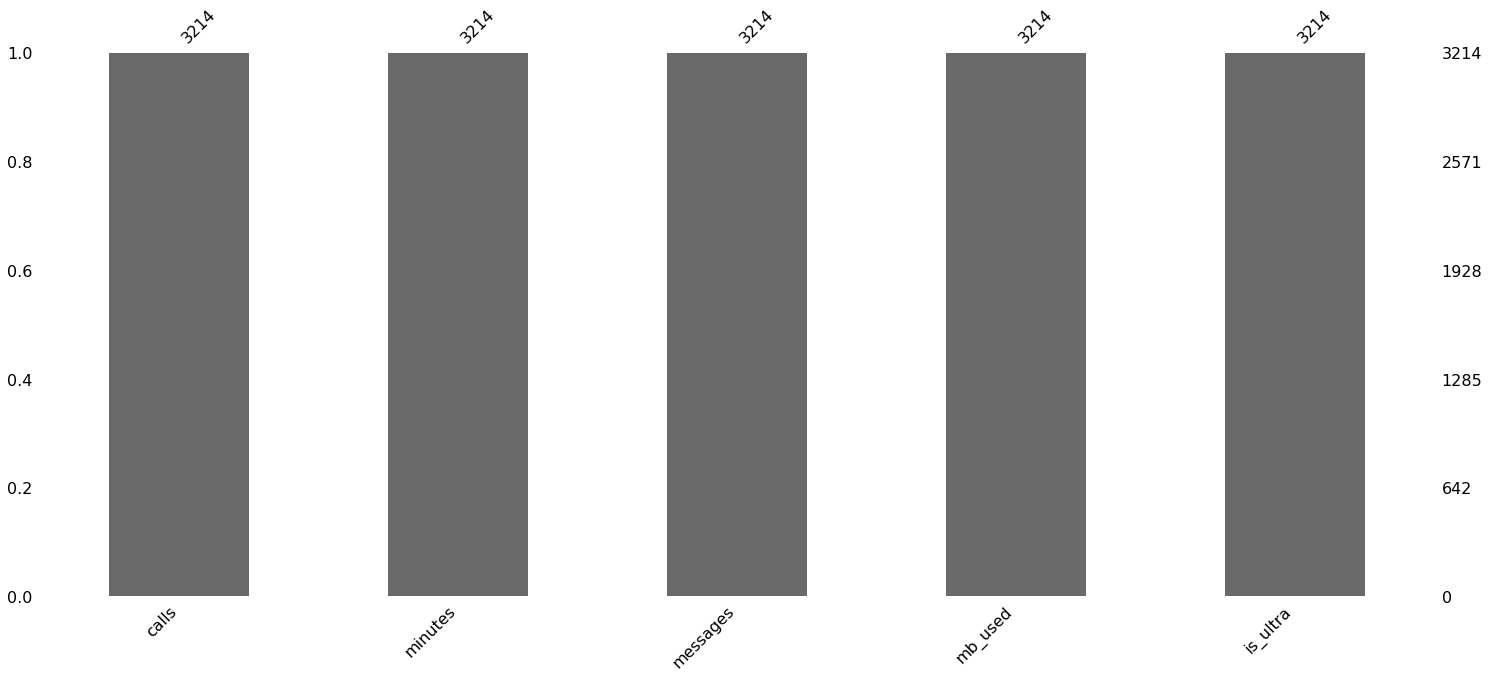

In [9]:
msno.bar(data)

<a id='section1_6'></a>
### Посмотрим описание столбцов датафрейма.

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.000000,62.000000,82.000000,244.000000
minutes,3214.0,438.208771,234.569870,0.0,274.574997,430.600006,571.927521,1632.060059
messages,3214.0,38.281269,36.148326,0.0,9.000000,30.000000,57.000000,224.000000
mb_used,3214.0,17207.673828,7570.968262,0.0,12491.902588,16943.234375,21424.699707,49745.730469
is_ultra,3214.0,0.306472,0.461100,0.0,0.000000,0.000000,1.000000,1.000000


<a id='section7'></a>
###  Промежуточные выводы.

В ходе изученния данных:
* сохранили файл в датафрейм `data`,
* вывели на экран и изучили:
    - первые строки датафрейма, 
    - метод `info()`,
    - метод `describe()`,
    - дубли,
    - пропуски.
* с  целью экономии памяти поменяли типы данных.
* явных дубликатов не выявили.
* пропусков не выявили.

__Дальнейшую предобработку данных делать не требуется.__

Проверим датасет на сбалансированность классов в целевом признаке `is_ultra`, вычислим и отобразим долю каждого класса в исходном датасете:

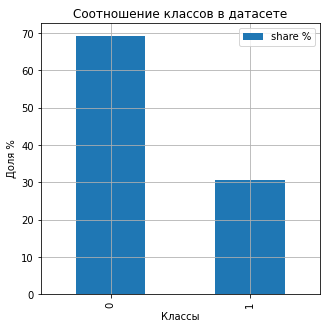

In [11]:
# Сформируем датасет с долями классов в исходном датасете
dt = pd.DataFrame(round(data.groupby('is_ultra')['is_ultra'].count() * 100 / data.shape[0], 2))
dt.columns = ['share %']
# Построим график
dt.plot(grid=True, figsize=(5, 5), kind='bar')
plt.xlabel('Классы')
plt.ylabel('Доля %')
plt.title('Соотношение классов в датасете')
plt.legend()
plt.show()

Из графика видно, что почти 70% данных в одном классе, а остальные 30% в другом классе.

Посмотрим корреляцию признаков:

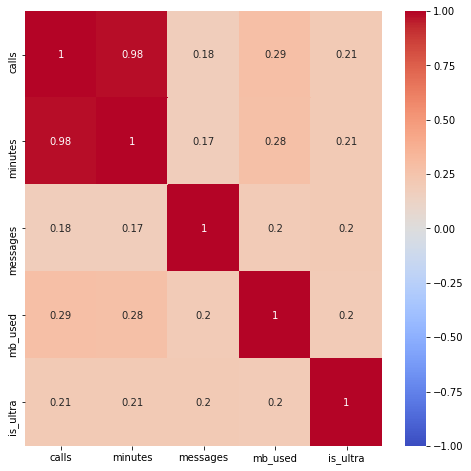

In [12]:
# создадим функцию для построения диаграммы корреляции признаков
def corr_matrix(data, columns):
    # сформируем матрицу корреляции
    corr_matrix = data[columns].corr()
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(
        corr_matrix,
        vmin=-1.,
        vmax=1.,
        annot=True,
        cmap='coolwarm'
    )
    plt.show()
# выведем корреляцию признаков
corr_matrix(data, ['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'])

Наблюдается мультиколлинеарность между количеством и продолжительность звонков. Более подробно информацию можно посмореть [тут](https://ru.wikipedia.org/wiki/Мультиколлинеарность#Последствия_мультиколлинеарности). Возможные методы устранения описаны [здесь](https://www.codecamp.ru/blog/multicollinearity-regression/).

В нашем проекте мы не будем устранять выявленную мультиколлинеарность, так как она влияет только на те признаки, которые коррелируют друг с другом.

<a id='section2'></a>
## Разделим данные на выборки.

В нашем проекте категориальный целевой признак это новый тариф: «Смарт» или «Ультра». Столбец `is_ultra`. Решается задача классификации.

Разделим исходные данные на обучающую, валидационную и тестовую выборки:

In [13]:
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

Спрятанной тестовой выборки нет. Поэтому, данные разобьем на три части: обучающую, валидационную и тестовую. Исходные данные разбивают в соотношении 3:1:1.

<a id='section2_1'></a>
### Обучающая выборка.

In [14]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.4, 
                                                                            random_state=12345,
                                                                            stratify=target
                                                                           ) 

Размер выборки обучающей выборки:

In [15]:
display(features_train.shape)
display(target_train.shape)

(1928, 4)

(1928,)

<a id='section2_2'></a>
### Валидационная и тестовая выборки.

In [16]:
features_valid, features_test, target_valid, target_test = train_test_split(features_test, 
                                                                            target_test, 
                                                                            test_size=0.5, 
                                                                            random_state=12345,
                                                                            stratify=target_test
                                                                           ) 

Размер валидационной выборки:

In [17]:
display(features_valid.shape)
display(target_valid.shape)

(643, 4)

(643,)

Размер тестовой выборки:

In [18]:
display(features_test.shape)
display(target_test.shape)

(643, 4)

(643,)

Посмотрим пропорции выборок на графике:

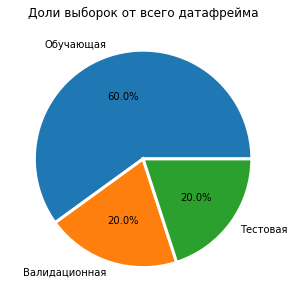

In [19]:
plt.figure(figsize=(5, 5))
plt.title('Доли выборок от всего датафрейма') 
shapes = [target_train.shape[0], target_valid.shape[0], target_test.shape[0]]
labels = ['Обучающая', 'Валидационная', 'Тестовая']
plt.pie(shapes, 
        labels=labels, 
        autopct='%1.1f%%', 
        wedgeprops = { 'linewidth': 3, 'edgecolor': 'white' })
plt.show()   

<a id='section3'></a>
## Исследуем модели.

<a id='section3_1'></a>
### Дерево решений `DecisionTreeClassifier`.

Сделаем 10 итераций с разными гиперпараметрами `max_depth`.

In [20]:
max_depth = 21
# заготовим пустые списки для дальнейшего анализа
depths =  list(range(1, max_depth))
train_accuracies = []
valid_accuracies = []
# подгоовим начальные переменные 
model_dtc = None
best_depth = 0
best_result = 0
for depth in tqdm(range(1, max_depth)):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if best_result < result:
        model_dtc = model
        best_depth = depth
        best_result = result
    # добавим результаты в списки
    valid_accuracies.append(result)
    predictions_train = model.predict(features_train)
    train_accuracies.append(accuracy_score(target_train, predictions_train))
accuracy_dtc = round(best_result, 3)

100%|██████████| 20/20 [00:00<00:00, 91.63it/s] 


In [21]:
display(f'Лучшая максимально допустимая глубина дерева max_depth = {best_depth}')
display(f'Лучшее качество accuracy = {accuracy_dtc}') 

'Лучшая максимально допустимая глубина дерева max_depth = 8'

'Лучшее качество accuracy = 0.802'

Построим графики качества модели на тренировочной и валидационной выборках в зависимости от глубины дерева:

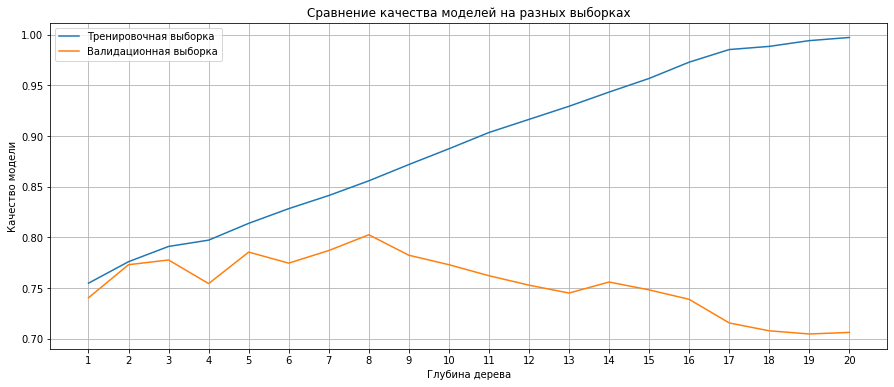

In [22]:
plt.figure(figsize=(15,6))
plt.grid()
plt.plot(depths, train_accuracies, label='Тренировочная выборка')
plt.plot(depths, valid_accuracies, label='Валидационная выборка')
plt.ylabel('Качество модели')
plt.xlabel('Глубина дерева')
plt.title('Сравнение качества моделей на разных выборках')
plt.xticks(depths)
plt.legend()
plt.show()

__Вывод:__

Качество лучшей модели алгоритма "Дерево решений" из десяти итераций равно `0.802` с максимально допустимой глубиной дерева равной `8`. 

Затраты ресурсов `125.13 итераций/сек`.

Построим дерево решений:

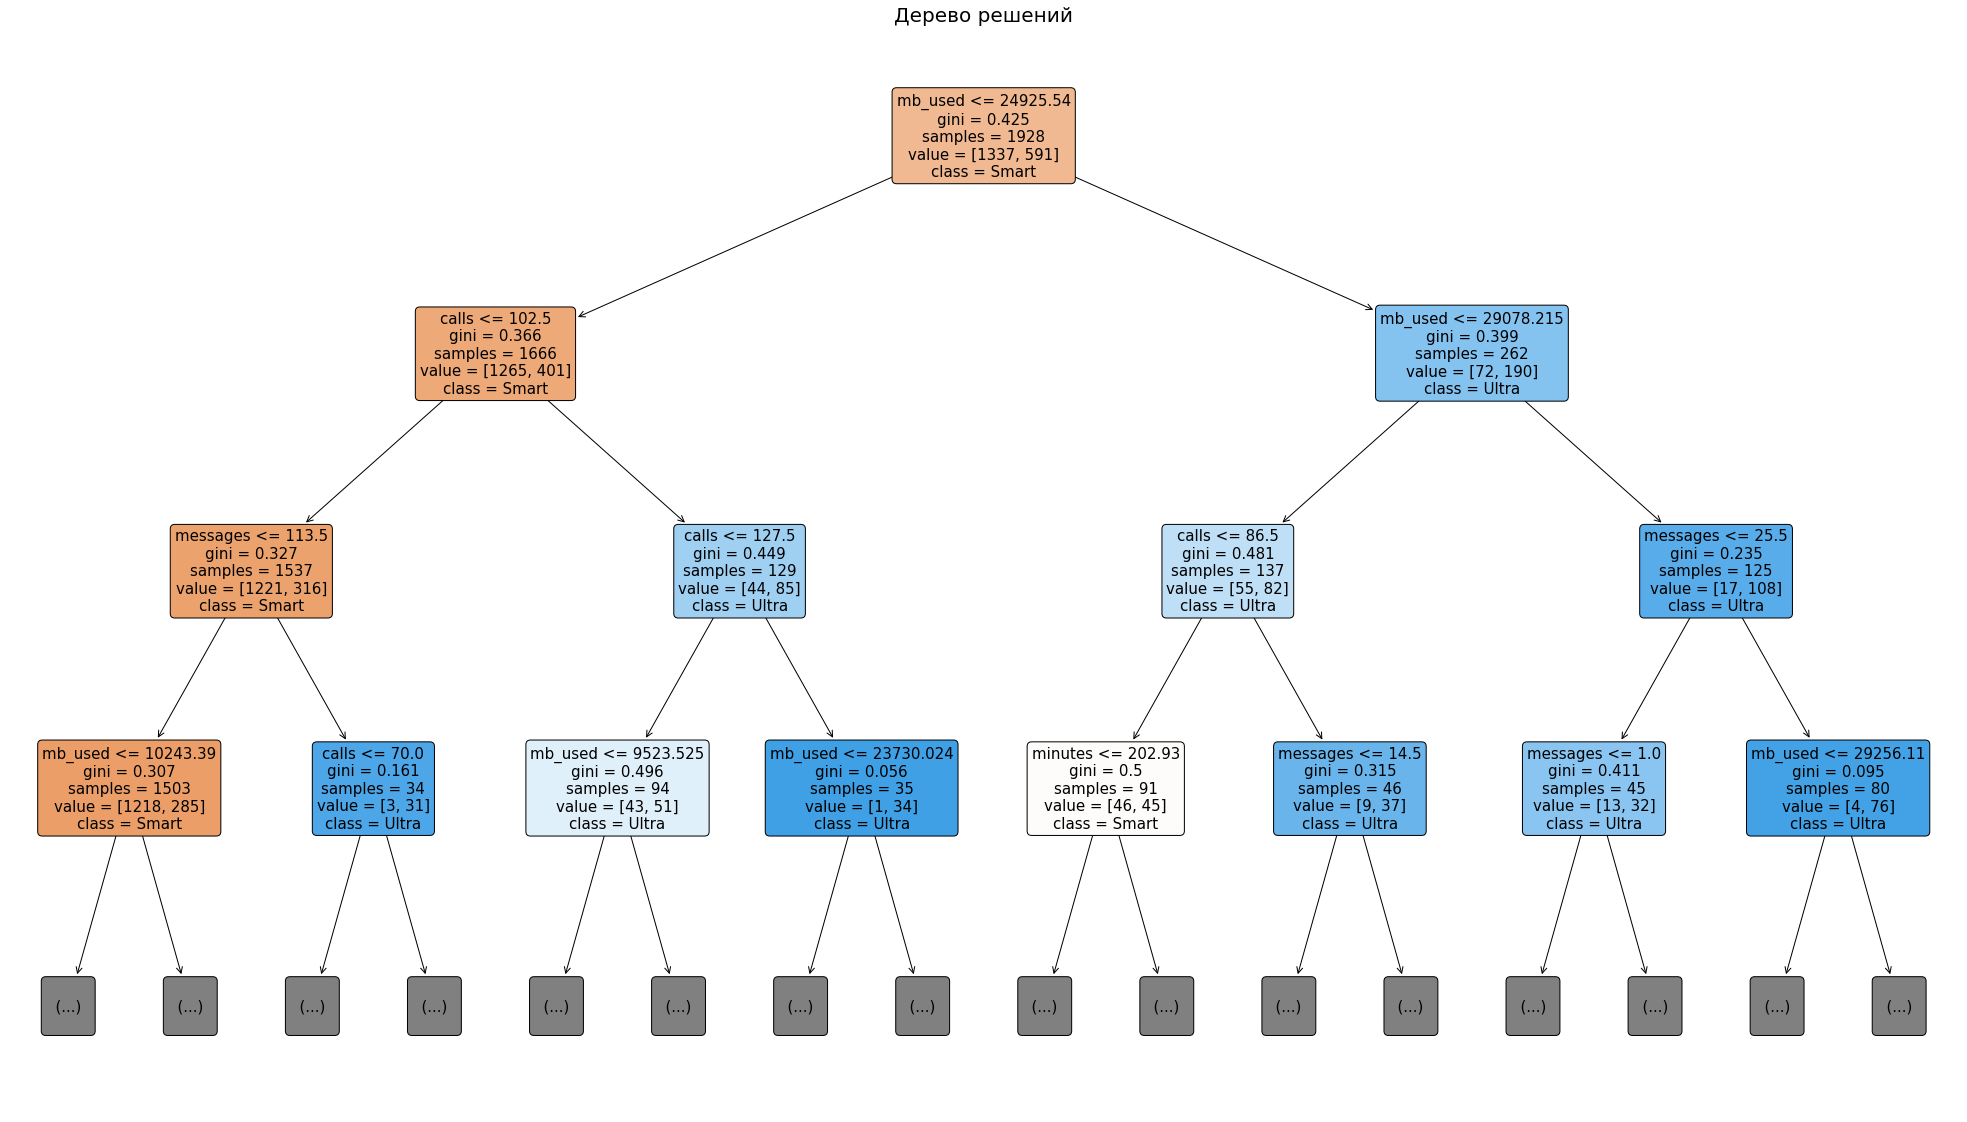

In [40]:
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(model_dtc, 
               feature_names=features.columns.values,  # Чтобы отображались названия признаков по которым делаются сплит
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15,
               rounded=True,
               max_depth = 3    
                  )
plt.title('Дерево решений', fontsize = 20)
plt.show()

<a id='section3_2'></a>
### Случайный лес `RandomForestClassifier`.

Сделаем по 10 итераций с разными гиперпараметрами `n_estimators` и `max_depth`.

In [24]:
model_rfc = None
best_est = 0
best_depth = 0
best_result = 0
for est in range(1, 11):
    for depth in tqdm(range(1, 11)):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if best_result < result:
            model_rfc = model
            best_est = est
            best_depth = depth
            best_result = result
accuracy_rfc = round(best_result, 3)

100%|██████████| 10/10 [00:00<00:00, 32.88it/s]


In [25]:
display(f'Лучшее "количество оценщиков" n_estimators = {best_est}')
display(f'Лучшая максимально допустимая глубина дерева max_depth = {best_depth}')
display(f'Лучшее качество accuracy = {accuracy_rfc}') 

'Лучшее "количество оценщиков" n_estimators = 6'

'Лучшая максимально допустимая глубина дерева max_depth = 6'

'Лучшее качество accuracy = 0.807'

__Вывод:__

Качество лучшей модели алгоритма "Случайный лес" из десяти итераций равно `0.807` с максимально допустимой глубиной дерева равной `6` и "количеством оценщиков" равным `6`. 

Затраты ресурсов при 1 "оценщике" `107.73 итераций/сек`, при 10 "оценщиках" `33.95 итераций/сек`.

<a id='section3_3'></a>
### Логистическая регрессия `LogisticRegression`.

In [26]:
model_lr = LogisticRegression(random_state=12345)
model_lr.fit(features_train, target_train)
predictions_valid = model_lr.predict(features_valid)
accuracy_lr = round(accuracy_score(target_valid, predictions_valid), 3)

display(f'Лучшее качество accuracy = {accuracy_lr}') 

'Лучшее качество accuracy = 0.739'

__Вывод:__

Качество модели алгоритма "Логистическая регрессия" равно `0.739`.

<a id='section4'></a>
## Выводы исследования модели.

Для сравнения качества моделей построим график:

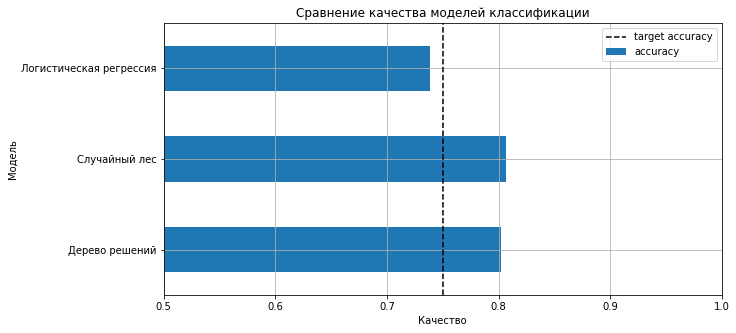

In [27]:
# создадим датафрейм с результатми моделей
dt = pd.DataFrame({'model': ['Дерево решений', 'Случайный лес', 'Логистическая регрессия'],
                   'accuracy': [accuracy_dtc, accuracy_rfc, accuracy_lr]})
# построим график
dt.plot(grid=True, figsize=(10,5), kind='barh')
plt.yticks(dt.index, dt['model'])
plt.ylabel('Модель')
plt.xlabel('Качество')
plt.xlim(0.5, 1)
plt.title('Сравнение качества моделей классификации')
# добавим линию "отсечки" с целевым качеством модели 0.75
plt.axvline(x = 0.75, color = 'black', label = 'target accuracy', linestyle='dashed')
plt.legend()
plt.show()

* Качество лучшей модели алгоритма "Дерево решений" из десяти итераций равно `0.802` с максимально допустимой глубиной дерева равной `8`. Затраты ресурсов `125.13 итераций/сек`.
* Качество лучшей модели алгоритма "Случайный лес" из десяти итераций равно `0.807` с максимально допустимой глубиной дерева равной `6` и "количеством оценщиков" равным `6`. Затраты ресурсов при 1 "оценщике" `107.73 итераций/сек`, при 10 "оценщиках" `33.95 итераций/сек`.
* Качество модели алгоритма "Логистическая регрессия" равно `0.739`.

__Таким образом, лучшая по качеству модель - модель алгоритма "Случайный лес" - `accuracy = 0.807`.__

<a id='section5'></a>
## Проверим модель на тестовой выборке.

Так как, лучшая по качеству модель "Случайный лес", проведем ее проверку на тестовой выборке:

In [28]:
model_rfc.fit(features_train, target_train)
predictions = model_rfc.predict(features_test)
accuracy_rfc_test = round(accuracy_score(predictions, target_test), 3)

display(f'Качество на тестовой выборке accuracy = {accuracy_rfc_test}') 

'Качество на тестовой выборке accuracy = 0.81'

__Вывод:__

__Качество модели "Случайный лес" на тестовой выборке равно `0.81`.__

Попробуем улучшить результат модели на объединенной тренировочной + валидационной выборке:

In [29]:
# объединим выборки
features_new = pd.concat([features_valid, features_train])
target_new = pd.concat([target_valid, target_train])
# проверим результат
display(features_new.shape)
display(target_new.shape)

(2571, 4)

(2571,)

Построим, обучим и проверим качество новой модели:

In [30]:
model_new = RandomForestClassifier(random_state=12345, n_estimators=6, max_depth = 6)
model_new.fit(features_new, target_new)
predictions_new = model_new.predict(features_new)
accuracy_new = round(accuracy_score(target_new, predictions_new), 2)
# посмотрим результат
display(f'Качество улучшенной модели accuracy = {accuracy_new}')

'Качество улучшенной модели accuracy = 0.82'

Качество улучшенной модели повысилось до `0.82`.

Проверим на тестовых данных:

In [31]:
model_new.fit(features_train, target_train)
predictions = model_new.predict(features_test)
accuracy_new_test = round(accuracy_score(predictions, target_test), 3)

display(f'Качество на тестовой выборке accuracy = {accuracy_new_test}') 

'Качество на тестовой выборке accuracy = 0.81'

__Вывод:__

__Качество улучшенной модели "Случайный лес" на тестовой выборке не изменилось и равно `0.81`.__

Посмотрим следующие метрики модели:

In [32]:
precision = round(precision_score(target_test, predictions), 3)
recall = round(recall_score(target_test, predictions), 3)
f1_score = round(f1_score(target_test, predictions), 3)
confusion_m = confusion_matrix(target_test, predictions)

display(f'Точность Precision = {precision}')
display(f'Полнота Recall = {recall}')
display(f'Общая оценка F1 Score = {f1_score}')
display('Матрица ошибок Confusion_matrix = ')
display(confusion_m)

'Точность Precision = 0.791'

'Полнота Recall = 0.518'

'Общая оценка F1 Score = 0.626'

'Матрица ошибок Confusion_matrix = '

array([[419,  27],
       [ 95, 102]])

<a id='section6'></a>
## Проверим модели на адекватность.

Для проверки адекватности нашей модели проведем сравнение ее качества с качеством модели `DummyClassifier`.  `DummyClassifier` это простой классификатор, который можно использовать в качестве эталонной модели.

In [33]:
model_dc = DummyClassifier(random_state=12345)
model_dc.fit(features_train, target_train)
accuracy_dc = round(model_dc.score(features_valid, target_valid), 3)

display(f'Качество модели "DummyClassifier" accuracy = {accuracy_dc}') 

'Качество модели "DummyClassifier" accuracy = 0.694'

In [34]:
display(f'Качество на тестовой выборке accuracy = {accuracy_rfc_test}') 

'Качество на тестовой выборке accuracy = 0.81'

__Вывод:__

__Качество модели "Случайный лес" на тестовой выборке `0.81` выше чем у модели "DummyClassifier" - `0.694`. Следовательно модель "Случайный лес" адекватна.__

<a id='section7'></a>
## Общий вывод.


* Изучили данные и выявили, что в данных пропусков, дублей и аномалий нет.
* Рассмотрели сбалансированность классов, корреляцию и мультколлинеарность признаков.
* Данные разбили на обучающую, валидационную и тестовую выборки в пропорции 3:1:1.
* В ходе исследования качества различных моделей определили что, лучшая по качеству модель - модель алгоритма "Случайный лес" `accuracy = 0.807` с максимально допустимой глубиной дерева равной `6` и "количеством оценщиков" равным `6`.
* Качество модели "Случайный лес" на тестовой выборке равно `accuracy = 0.81`.
* Качество улучшенной модели "Случайный лес" на тестовой выборке не изменилось и равно `0.81`.
* Качество модели "Случайный лес" на тестовой выборке `0.81` выше чем у модели "DummyClassifier" - `0.694`. Следовательно модель "Случайный лес" адекватна.

__Таким образом,  для построения системы, способной проанализировать поведение клиентов и предложить пользователям новый тариф «Смарт» или «Ультра», целесообразно использовать модель алгоритма "Случайный лес" с максимально допустимой глубиной дерева равной `6` и "количеством оценщиков" равным `6`.__

<a id='section8'></a>
## Чек-лист готовности проекта.

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
